In [1]:
from data.visualise import grid_psfs, show_psf_axial


In [2]:
RANDOM_SEED = 42

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 1.0
(100, 32, 32)


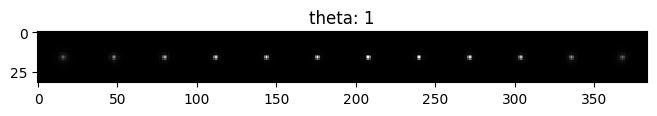

Time taken: 0.153s
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 34.52013
(100, 32, 32)


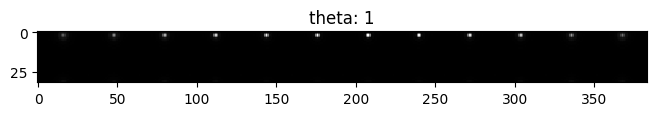

Time taken: 0.152s
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 34.52013
(100, 32, 32)


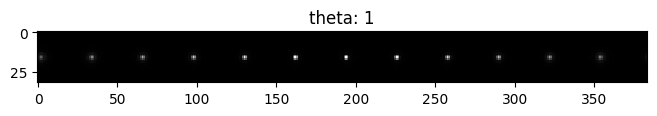

Time taken: 0.154s
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 24.067257
(100, 32, 32)


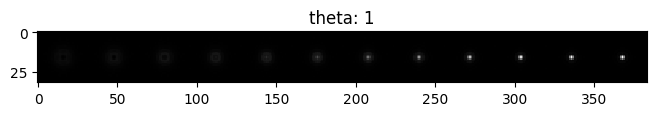

Time taken: 0.154s
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 5.2799582
(100, 32, 32)


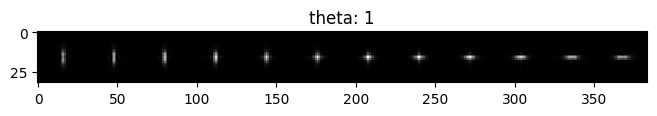

Time taken: 0.153s
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 8.431389
(100, 32, 32)


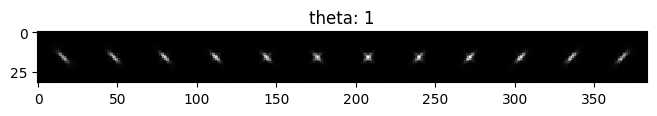

Time taken: 0.154s
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
RMS 44.143253
(100, 32, 32)


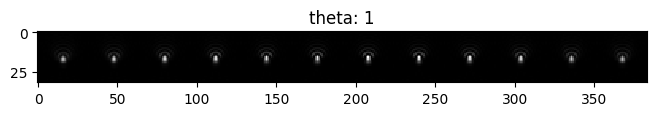

Time taken: 0.154s
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
RMS 44.14325
(100, 32, 32)


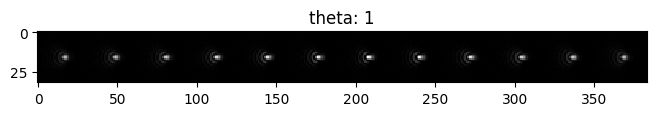

Time taken: 0.155s
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
RMS 17.53252
(100, 32, 32)


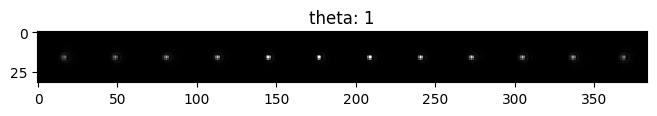

Time taken: 0.154s
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
RMS 17.285671
(100, 32, 32)


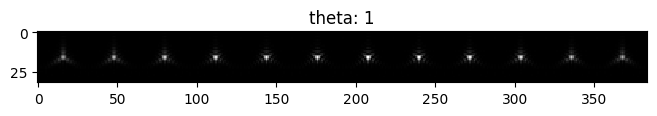

Time taken: 0.155s
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
RMS 411.46396
(100, 32, 32)


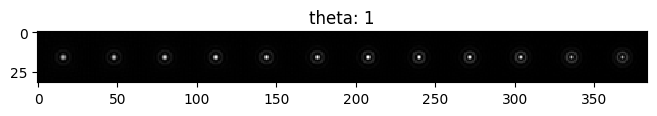

Time taken: 0.154s
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
RMS 108.87894
(100, 32, 32)


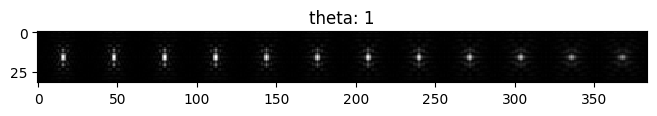

Time taken: 0.154s


In [52]:
import jax.numpy as np
import jax

try:
    import cupy as cp

    print('cupy imported')
    import_cp = True
except:
    import_cp = False

import matplotlib.pyplot as plt


def rms(pupil):
    return np.sqrt(np.sum(pupil**2) / np.sum(pupil <= 1))
          
class Simulator:
    
    
# pixel size (nm) - 115
# step size (nm) - 20nm
# magnification - 100x
# illumination NA
# NA at sample
# refractive index at sample - PBS so 1.335
# illumination wavelength - 635nm
# detection wavelength - to check


    xp = np
    acc = None
    
# #     N = 2048  # points to use in FFT
#     Nn = 32
#     pixel_size = 0.115  # camera pixel size
#     zrange = 1.0  # distance either side of focus to calculate, in microns, could be arbitrary
#     dz = 0.02  # step size in axial direction of PSF
    
#     magnification = 100  # objective magnification
#     ill_NA = 1.4  # numerical aperture at illumination beams
#     det_NA = 1.1  # numerical aperture at sample
#     n = 1.335  # refractive index at sample
#     fwhmz = 3.0  # FWHM of light sheet in z

#     ill_wavelength = 635  # illumination wavelength in nm
#     det_wavelength = 635  # detection wavelength in nm

    def __init__(self, Nn=32, pixel_size=0.115, zrange=1.0, dz=0.02, magnification=100, ill_NA=1.4, det_NA=1.1, n=1.335, fwhmz=3.0, ill_wavelength=635, det_wavelength=635):
        if self.acc == 3:
            self.xp = cp
            
        self.Nn = Nn # lateral size of output PSF
        self.pixel_size = pixel_size
        self.zrange = zrange
        self.dz = dz # step size in axial direction of PSF
        self.magnification = magnification
        self.ill_NA = ill_NA # numerical aperture at illumination beams
        self.ill_wavelength = ill_wavelength # illumination wavelength in nm
        self.det_NA = det_NA # numerical aperture at sample
        self.det_wavelength = det_wavelength # detection wavelength in nm
        
        self.n = n # refractive index at sample
        self.fwhmz = fwhmz
        
        
#         np.random.seed(RANDOM_SEED)
        # self.seed(1234)  # set random number generator seed
        self.ill_wavelength = self.ill_wavelength * 1e-3
        self.det_wavelength = self.det_wavelength * 1e-3
        self.sigmaz = self.fwhmz / 2.355
        self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
        self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
#         self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        
        self.N = self.Nn * (self.det_wavelength / (4 * self.det_NA)) / (self.pixel_size / self.magnification)

        self.dxn = self.N * self.dx / self.Nn  # correct spacing
        self.res = self.det_wavelength / (2 * self.det_NA)
        oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
        self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
        self.k0 = 2 * np.pi * self.n / self.det_wavelength
        self.kx, self.ky = self.xp.meshgrid(self.xp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
                                       self.xp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
        self.kr = np.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
        
        self.krmax = self.det_NA * self.k0 / self.n
        self.kr2 = self.kx ** 2 + self.ky ** 2
        self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

        self.alpha = np.arcsin(self.det_NA / self.n)
        # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
        self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - np.cos(self.alpha)))
        self.Nz = int(2 * np.ceil(self.zrange / self.dz))
        self.dz = 2 * self.zrange / self.Nz
        self.Nzn = int(2 * np.ceil(self.zrange / self.dzn))
        self.dzn = 2 * self.zrange / self.Nzn
        if self.Nz < self.Nzn:
            self.Nz = self.Nzn
            self.dz = self.dzn
        else:
            self.Nzn = self.Nz
            self.dzn = self.dz
        if (self.acc == 1) | (self.acc == 2):
            self._tdev = torch.device('cuda' if self.acc == 2 else 'cpu')

    
    def get_scalar_psf(self, zern_coefs=None):
        # use krmax to define the pupil function
        kx = self.krmax * self.kx
        ky = self.krmax * self.ky
        kr2 = (kx ** 2 + ky ** 2)  # square kr
        # 2 * np.pi * self.n / self.wavelength
        kz = self.xp.sqrt((self.k0 ** 2 - kr2) + 0j)
        psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
        pupil = self.kr
#######################################################
# MODIFIED SECTION
        extra_aberration = np.zeros(self.kr.shape)
        aberrations = np.array([
            np.ones(self.kr.shape), # piston
            2 * self.kx, # tip
            2 * self.ky, # tilt
            np.sqrt(3) * ((2 * (self.kr**2)) - 1), # defocus
            np.sqrt(6) * (self.kx**2 - self.ky ** 2), # oblique astigmatism
            2 * np.sqrt(6) * (self.kx * self.ky), # vertical astigmatism
            2 * np.sqrt(2) * (3 * self.kr**2 - 2) * self.kx, # vertical coma
            2 * np.sqrt(2) * (3 * self.kr**2 - 2) * self.ky, # horizontal coma
            2 * np.sqrt(2) * (3 * self.kr**2 - 4 * self.kr**2) * self.ky, # vertical trefoil 
            2 * np.sqrt(2) * (4 * self.kx**2 - 3 * self.kr**2) * self.kx, # oblique trefoil 
            np.sqrt(5) * (6 * self.kr**2 * (self.kr**2 - 1) + 1), # primary spherical
            np.sqrt(10) * (8 * self.kx**4 - 8 * self.kx**2 * self.ky**2 - (3 * self.kx ** 2)), # vertical secondary astigmatism
            np.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
            np.sqrt(10) * ((self.kx**2 - self.ky**2) * (4*self.kx**2 - 3)) ** 2, # vertical quadrafoil
            np.sqrt(10) * ((2 * self.kx * self.ky) * (self.kx**2 - self.ky**2)) ** 2 # oblique quadrafoil
        ])
        if zern_coefs is not None:
            n_coefs = zern_coefs.shape[0]
            aberrations = aberrations[:n_coefs]
            extra_aberration = np.multiply(aberrations, zern_coefs[:, np.newaxis, np.newaxis]).sum(axis=0)
        else:
            extra_aberration = 0
        print('RMS', rms(extra_aberration))

        pupil = pupil < 1
    

#         nz = 0
#         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(1j * (extra_aberration + z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf = psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1

        mult1 = self.n * 2 * np.pi / self.det_wavelength * np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
        zs = np.arange(-self.zrange, self.zrange, self.dzn)
        cs = jax.lax.map(lambda z: (np.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
        cs_psf = abs(np.fft.fftshift(np.fft.ifft2(cs), axes=(1,2))) ** 2
        psf = np.multiply(cs_psf, np.exp(-zs ** 2 / 2 / self.sigmaz ** 2)[:, np.newaxis, np.newaxis])
        
    
        # Normalised so power in resampled psf(see later on) is unity in focal plane
        psf = psf * self.Nn ** 2 / self.xp.sum(pupil) * self.Nz / self.Nzn
        return psf


s = Simulator()

phase = 1

import time

for abb_mode in range(0, 12):
    t1 = time.time()
    zerns = np.zeros((15,))
    zerns = zerns.at[abb_mode].add(phase)
    print(zerns)
    psf2 = s.get_scalar_psf(zern_coefs=zerns)
    print(psf2.shape)
#     import hashlib
#     print(hashlib.md5(psf2.tobytes()).digest())
    show_psf_axial(psf2 / psf2.max(), 'theta: ' + str(round(phase, 3)), 5)
    t2 = time.time()
    print(f'Time taken: {round(t2-t1, 3)}s')



(6,)
mmax 3.2857203e-10 0.031093402


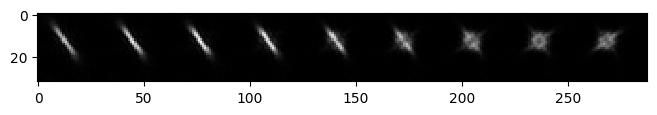

[-2.         2.6075814  2.6169004  0.624557   0.5598725  1.6506768]


In [19]:
def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())

n_coefs = 6
target_coefs = jax.random.uniform(key=jax.random.PRNGKey(RANDOM_SEED), shape=(n_coefs,)) * 3
target_coefs = target_coefs.at[0].set(-2)
target_psf = s.get_scalar_psf(zern_coefs=target_coefs)
print('mmax', target_psf.min(), target_psf.max())
target_psf = norm_zero_one(target_psf)
show_psf_axial(target_psf)
print(target_coefs)

Early stopping (tol reached)-07 - Patience: 0

Restoring weights from best epoch {'epoch': 229, 'mse': 9.071363393786669e-08, 'lr': 1e-07, 'pcoef_0': 0.6878003, 'pcoef_1': 2.606761, 'pcoef_2': 2.613479, 'pcoef_3': 0.623903, 'pcoef_4': 0.55935115, 'pcoef_5': 1.6499366, 'pcoef_6': 0.00038782434}


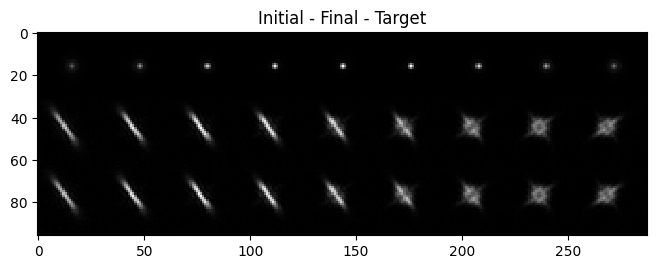

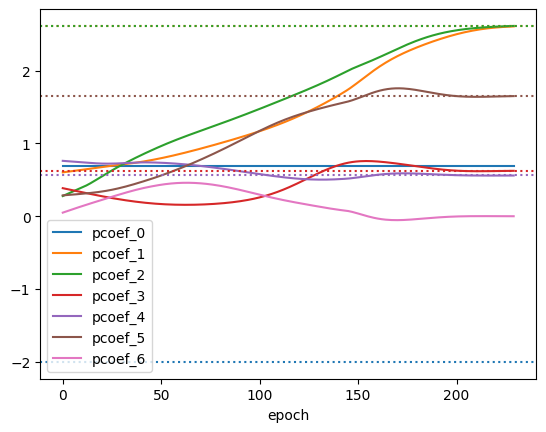

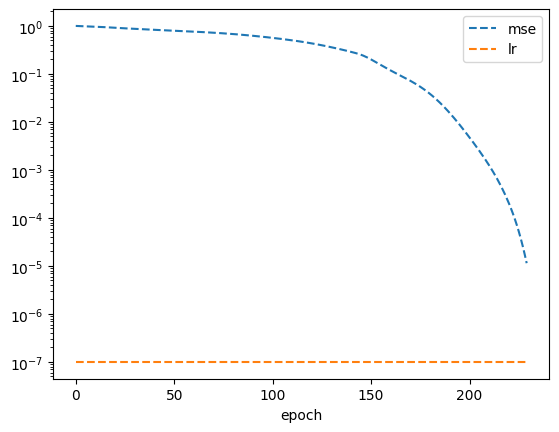

In [12]:
import jax 
from jax.example_libraries.optimizers import adam
from functools import partial
from tqdm import trange
from tqdm.notebook import tqdm
import pandas as pd

def diff_func(zern_coefs, simulator, target_psf):
    psf = simulator.get_scalar_psf(zern_coefs=zern_coefs)
    psf = norm_zero_one(psf)
    return np.mean(np.square(psf-target_psf)) 


def optimize_model(simulator, target_psf, n_coefs, target_pcoefs=None, plot=True, lr=0.001):
#     target_psf = (target_psf * 255 * 255).astype(np.int64)
    
#     target_psf = prep_data_for_PR(target_psf, multiplier=1.1)
#     target_psf = target_psf / target_psf.max()

    initial_pcoefs = jax.random.uniform(key=jax.random.PRNGKey(RANDOM_SEED), shape=(n_coefs,))

    
    opt_init, opt_update, get_params = adam(1)
    opt_state = opt_init(initial_pcoefs.copy())

    func = partial(diff_func, simulator=simulator, target_psf=target_psf)
    
    def step(step, opt_state, lr):
        value, grads = jax.value_and_grad(func)(get_params(opt_state))
        grads *= lr
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    early_stop_patience = 100
    early_stop_count = 0
    
    reduce_lr_patience = 25
    reduce_lr_count = 0
    
    all_data = []
    tol = 1e-7

    best_mse = np.inf
    best_iter = None
    best_coefs = None
    ITER = 1000
    with tqdm(total=ITER, position=0, leave=True) as pbar:
        for i in range(ITER):
            value, opt_state = step(i, opt_state, lr)
            log_data = {
                'epoch': i,
                'mse': float(value),
                'lr': lr
            }
            for pcoef, val in enumerate(opt_state.packed_state[0][0].real._value):
                log_data[f'pcoef_{pcoef}'] = val

            all_data.append(log_data)
            mse_val = float(value)
            if best_mse < mse_val and best_mse - mse_val < best_mse * 0.01:
                early_stop_count += 1
                if early_stop_count == early_stop_patience:
                    print('Early stopping (no progress)')
                    break
                    
                reduce_lr_count += 1
                if reduce_lr_count == reduce_lr_patience:
                    reduce_lr_count = 0
                    lr /= 10
            else:
                early_stop_count = 0
                reduce_lr_count = 0

            if mse_val < best_mse:
                best_coefs = opt_state.packed_state[0][0].real._value.copy()
                best_iter = log_data
                best_mse = mse_val
            
            if mse_val < tol:
                print('Early stopping (tol reached)')
                break
            print(''*50, end='\r')
            print(f'{i} MSE: {"%.4E" % round(value, 20)} - lr: {lr} - Patience: {early_stop_count}', end='\r')
            pbar.update(1)
    
    final_coefs = best_coefs
    print(f'Restoring weights from best epoch {best_iter}')
    
    if plot:
        final_psf = simulator.get_scalar_psf(zern_coefs=final_coefs)

        final_psf = final_psf / final_psf.max()

        initial_psf = simulator.get_scalar_psf()
        initial_psf = initial_psf / initial_psf.max()
        target_psf = target_psf / target_psf.max()

        comparison = np.concatenate((initial_psf, final_psf, target_psf), axis=2)
        plt.title('Initial - Final - Target')
        show_psf_axial(comparison)

        df = pd.DataFrame.from_records(all_data, index='epoch')
        df['mse'] = df['mse'] / df['mse'].max()

        
        coefs = [c for c in list(df) if 'coef' in c]
        ax = df[coefs].plot()
        
        if target_pcoefs is not None:
            for i, val in enumerate(target_pcoefs):
                plt.axhline(xmin=0, xmax=df.shape[0]-1, y=val, color=ax.lines[i].get_color(), linestyle='dotted', label='_Hidden')
        plt.ylabel('')
        plt.show()
        
        df[['mse', 'lr']].plot(linestyle='--')
        plt.yscale('log')
        plt.show()

    return final_coefs, all_data

def fit_psf(target_psf, optical_params, n_coefs=7, lr=1e-4, target_pcoefs=None):
    simulator = Simulator(**optical_params)
    

    best_coefs, data = optimize_model(simulator, target_psf, n_coefs, lr=lr, target_pcoefs=target_pcoefs)

fit_psf(target_psf, {}, lr=1e-7, target_pcoefs=target_coefs)

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
from tifffile import imread
import h5py
import numpy as _np

sys.path.append('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/src/smlm_z/pipelines')
from preprocessing.nodes import extract_training_stacks

bead_stack = imread('/home/miguel/Projects/uni/data/smlm_3d/MQ_20230322/bead/3um_stack_20nm_step_20nm_bead_1/3um_stack_20nm_step_20nm_bead_1_MMStack_Default.ome.tif')
with h5py.File('/home/miguel/Projects/uni/data/smlm_3d/MQ_20230322/bead/3um_stack_20nm_step_20nm_bead_1/3um_stack_20nm_step_20nm_bead_1_MMStack_Default_slice.ome_spots.hdf5') as f:
    spots = _np.array(f['spots'])
    

from skimage.feature import match_template

parameters = {
    'picasso': {
        'spot_size': 31,
        'localised_frame': bead_stack.shape[0]//2
    },
    'DEBUG': False
}
stacks = extract_training_stacks(spots, bead_stack, parameters)
print(stacks.shape)


In [ ]:
for i in range(20):
    target_psf = stacks[i]
    show_psf_axial(target_psf, str(i))

In [ ]:
from pyotf.utils import prep_data_for_PR

target_spot = 16

target_psf = stacks[target_spot]

target_psf = prep_data_for_PR(target_psf, multiplier=1.1)


target_psf = norm_zero_one(target_psf)


z_range = int(target_psf.shape[0]/2)*2
target_psf = target_psf[:z_range]

z_range /= 100


optical_params = dict(Nn=target_psf.shape[1], 
                          pixel_size=0.110, 
                          zrange=z_range, 
                          dz=0.02, 
                          magnification=111.11,
                          ill_NA=1.4,
                          det_NA=1.1,
                          n=1.335,
                          fwhmz=3.0,
                          ill_wavelength=635,
                          det_wavelength=635)




show_psf_axial(target_psf)

fit_psf(target_psf, optical_params, n_coefs=12, lr=1e-6)